# PyStochasticVolatility Compilation

This notebook is a self-contained version of all relevant PSV functions compiled for informative purposes.  Main goal is to explain everything that goes into running the Heston Model Monte Carlo simulation.

 The following files are here: 
* `Heston_Tools.py` 
* `VarianceMC.py`
* `MC_Heston.py`
* `EuropeanInstruments.py` (only relevant variables)

Not directly here but referenced via module: 
* `Types.py` - MC with variance reduction using control variates (they only use it to have ndarray and sampling techniques 

In [11]:
# If using jupyter notebook
import sys
sys.path.append('/Users/elainbalderas/Library/CloudStorage/GoogleDrive-elain.balderas@bse.eu/My Drive/DSM 2022-2023 /Master Project/PyStochasticVolatility')

In [37]:
# Run if using colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
%cd 'gdrive/MyDrive/DSM 2022-2023 /Master Project/PyStochasticVolatility'

/content/gdrive/MyDrive/DSM 2022-2023 /Master Project/PyStochasticVolatility


In [49]:
# installing dependencies 
# !pip install time 
# !pip install prettytable
# !pip install tabulate
#!pip install sobol_seq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# EuropeanInstruments.py

In [ ]:
class EuropeanOption(object):
    def __init__(self,
                 strike: float,
                 notional: float,
                 buy_sell: TypeSellBuy,
                 option_type: TypeEuropeanOption,
                 spot: float,
                 delta_time: float):
      
      #  initialize the class attributes and calculate payoff of the option based on its type (call or put) and the buy/sell indicator

        self._strike = strike
        self._notional = notional
        self._option_type = option_type
        self._buy_sell = buy_sell
        self._spot = spot
        self._delta_time = delta_time
        # self._payoff_control_variate

        if buy_sell == TypeSellBuy.BUY:
            mult_buy_sell = 1.0
        else:
            mult_buy_sell = -1.0

        if option_type == TypeEuropeanOption.CALL:
            self._payoff = EuropeanPayoff(lambda x: mult_buy_sell * notional * call_operator(x, strike))
        else:
            self._payoff = EuropeanPayoff(lambda x: mult_buy_sell * notional * put_operator(x, strike))

    def update_strike(self, strike: float):  # update the strike price of the option
        self._strike = strike

    def get_price(self, x: ndarray) -> ndarray: # calculates option price based on the current spot price
        if len(x.shape) == 1:
            return self._payoff.get_value(x)
        else:
            return self._payoff.get_value(x[:, -1])

    def get_price_control_variate(self, x: ndarray, int_v_t: ndarray): #  calculates option price using variance reduction technique
        vol_swap_t_i = np.sqrt(np.sum(int_v_t, axis=1) / self._delta_time)
        if self._option_type == TypeEuropeanOption.CALL:
            price = call_operator_control_variate(x, self._spot, vol_swap_t_i, self._strike, self._delta_time)
        else:
            price = put_operator_control_variate(x, self._spot, vol_swap_t_i, self._strike, self._delta_time)

        if self._buy_sell == TypeSellBuy.BUY:
            alpha = 1.0
        else:
            alpha = -1.0

        return self._notional * alpha * price

## Heston_Tools.py
### Conditional mean (`v_t_conditional_mean`)

We have:
$$\delta_t = t_i - t_{i-1}$$
$$ \text{Conditional mean}= \theta + (v_{t_{i-1}}- \theta) * e^{-k\delta t} $$

where:
* $ \delta_t $ = time step
* $ \theta $ = long-term average value 
* $ k $ = rate of mean reversion
* $ v_t $ = current value at time t 
* $ v_{t_{i-1}} $ = value at previous observation 

In [ ]:
def v_t_conditional_mean(k: float,
                         theta: float,
                         v_t_i_1: float,
                         t_i_1: float,
                         t_i: float):
    """
    Computes the conditional mean of the Heston model.
    """
    delta_time = (t_i - t_i_1)
    return theta + (v_t_i_1 - theta) * np.exp(- k * delta_time)

### Conditional variance 

$$ e^{kt} = \frac{(1.0 - e^{-k\delta t})}{k}$$ 

$$ \mathbb{V}[V(t+\delta t)|V(t) = v_t] = \epsilon^2 \times (v_{t_{i-1}} \times e^{-k \times \delta_t} \times e^{k_t} + 0.5 \times \theta \times k \times e^{2k_t}) $$

where:
* $ \epsilon $ = volatility of volatility parameter

In [ ]:
def v_t_conditional_variance(k: float,
                             theta: float,
                             epsilon: float,
                             v_t_i_1: float,
                             t_i_1: float,
                             t_i: float):
    """
    Computes the conditional variance. 
    """
    delta_time = (t_i - t_i_1)
    exp_k_t = (1.0 - np.exp(- k * delta_time)) / k
    return epsilon * epsilon * (v_t_i_1 * np.exp(- k * delta_time) * exp_k_t + 0.5 * theta * k * exp_k_t * exp_k_t)


## Lognormal distribution
$$\phi_{t_i} = \frac{s_2}{m^2} $$
$$ \phi_{t_i}^{-1} = \frac{1}{\phi_{t_i}} $$

Auxiliary variable: 
$$ b^2 = 2 \times \phi_{t_i}^{-1} - 1 $$

Parameters are given by: 
$$ \text{parameter[0]} = \sqrt{b^2 + \sqrt{b^2\times(b^2+1)}} $$
$$ \text{parameter[1]} = \frac{m}{1 + \text{parameter[0]}^2} $$ 


In [ ]:
def matching_qe_moments_qg(m: float,
                           s2: float):
    parameters = np.empty(2)
    
    """
    Mean and variance of the lognormal distribution.
    """

    phi_t_i = s2 / (m * m)
    inv_phi_t_i = 1.0 / phi_t_i
    aux_b_2 = 2.0 * inv_phi_t_i - 1.0
    parameters[0] = np.sqrt(aux_b_2 + np.sqrt(aux_b_2 * (aux_b_2 + 1.0)))
    parameters[1] = m / (1.0 + np.power(parameters[0], 2.0))

    return parameters

## Exponential distribution
 
 $$\phi_{t_i} = \frac{s_2}{m^2} $$

Parameters are given by: 
$$ \text{mean} = \frac{\phi_{t_i} - 1}{\phi_{t_i} +1} $$
$$ \text{variance} = \frac{1 - \text{mean}}{m} $$ 


In [ ]:
def matching_qe_moments_exp(m: float,
                            s2: float):
    parameters = np.empty(2)

    phi_t_i = s2 / (m * m)
    parameters[0] = (phi_t_i - 1.0) / (phi_t_i + 1.0)
    parameters[1] = (1.0 - parameters[0]) / m

    return parameters

## Other functions in Heston_Tools.py

In [44]:
from Tools.Types import ndarray
def inv_exp_heston(p: float,
                   beta: float,
                   u: float):
    """
    Inverse exponential distribution. 
    """
    if u < p:
        return 0.00001
    else:
        return np.log((1.0 - p) / (1.0 - u)) / beta


def get_integral_variance(t_i_1: float,
                          t_i: float,
                          v_t_i_1: ndarray,
                          v_t_i: ndarray,
                          w_i_1: float,
                          w_i: float):
    """
    Used to calculate integral of the variance between two points in time in an MC simulation. 
    """
    delta = (t_i - t_i_1)
    return delta * (w_i_1 * v_t_i_1 + w_i * v_t_i)


#### GREEK COMPUTATION ####

def get_delta_weight(t_i_1, t_i, v_t_i_1, v_t_i, w_i_f, delta_weight):
    alpha1 = 1.0
    alpha2 = 0.0
    no_paths = len(w_i_f)
    sqr_delta_time = np.sqrt(t_i - t_i_1)
    for i in range(0, no_paths):
        delta_weight[i] += w_i_f[i] * sqr_delta_time * ((alpha1 / np.sqrt(v_t_i_1[i])) + (alpha2 / np.sqrt(v_t_i[i])))


def get_var_weight(t_i_1, t_i, v_t_i_1, v_t_i, w_i_f,  var_weight):
    alpha1 = 0.5
    alpha2 = 0.5
    no_paths = len(w_i_f)
    sqr_delta_time = np.sqrt(t_i - t_i_1)
    for i in range(0, no_paths):
        var_weight[i] += w_i_f[i] * sqr_delta_time * ((alpha1 / np.sqrt(v_t_i_1[i])) + (alpha2 / np.sqrt(v_t_i[i])))


def get_gamma_weight(delta_weight, var_weight, inv_variance, rho, t,  gamma_weight):
    no_paths = len(delta_weight)
    rho_c = np.sqrt(1.0 - rho * rho)
    for i in range(0, no_paths):
        gamma_weight[i] = np.power(var_weight[i], 2.0) - inv_variance[i] - rho_c * t * delta_weight[i]

## Heston Variance Computation 


In [45]:
from Tools.Types import ndarray
from MC_Engines.MC_Heston import HestonTools
from scipy.special import ndtri

def get_variance(k: float,
                 theta: float,
                 epsilon: float,
                 phi_switch_level: float,
                 t_i_1: float,
                 t_i: float,
                 v_t_i_1: ndarray,
                 u_i: ndarray,
                 no_paths: int):

    # no_paths = len(v_t_i_1)
    paths = np.zeros(no_paths)

    for i in range(0, no_paths):
      # Compute conditional variance, and conditional mean 
        s_2_i = HestonTools.v_t_conditional_variance(k, theta, epsilon, v_t_i_1[i], t_i_1, t_i)
        m_i = HestonTools.v_t_conditional_mean(k, theta, v_t_i_1[i], t_i_1, t_i)
        phi = s_2_i / (m_i * m_i)
        # Eli just added this part 
        if m_i == 0:
            phi = 0
        else:
            phi = s_2_i / (m_i * m_i)

        # If less than threshold phi, compute using lognormal distribution. Otherwise, use exponential. 
        if phi < phi_switch_level:
            parameters = HestonTools.matching_qe_moments_qg(m_i, s_2_i)
            z_i = ndtri(u_i[i], dtype=np.float64)
            paths[i] = parameters[1] * np.power(parameters[0] + z_i, 2.0)
        else:
            parameters = HestonTools.matching_qe_moments_exp(m_i, s_2_i)
            paths[i] = HestonTools.inv_exp_heston(parameters[0], parameters[1], u_i[i])

    return paths

# Heston Engine 

`get_time_steps`:
Function to get number of time steps, with time steps generated equally spaced based on initial and final time, unless extra sampling points are specified. 
With extra sampling points, they are combined with no_time_steps, then randomized.

`get_path_multi_step`: MC implementation for Heston model.


In [46]:
import numpy as np

from Tools.Types import Vector, ndarray, HESTON_OUTPUT
from MC_Engines.MC_Heston import HestonTools, VarianceMC
from Tools import AnalyticTools, Types

def get_time_steps(t0: float, t1: float, no_time_steps: int, **kwargs):
    if len(kwargs) > 0:
        extra_points = kwargs['extra_sampling_points']
        basis_sampling_dates = np.linspace(t0, t1, no_time_steps).tolist()
        full_points = np.array(list(set(extra_points + basis_sampling_dates)))
        return sorted(full_points)
    else:
        return np.linspace(t0, t1, no_time_steps)


def get_path_multi_step(t0: float,
                        t1: float,
                        parameters: Vector,
                        f0: float,
                        v0: float,
                        no_paths: int,
                        no_time_steps: int,
                        type_random_numbers: Types.TYPE_STANDARD_NORMAL_SAMPLING,
                        rnd_generator,
                        **kwargs) -> ndarray:

# initialize all parameters 
    k = parameters[0]
    theta = parameters[1]
    epsilon = parameters[2]
    rho = parameters[3]

    no_paths = 2 * no_paths if type_random_numbers == Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC else no_paths

# calculate no. of time steps 
    t_i = get_time_steps(t0, t1, no_time_steps, **kwargs)
    no_time_steps = len(t_i)

    t_i = np.linspace(t0, t1, no_time_steps)
    delta_t_i = np.diff(t_i)

    f_t = np.empty((no_paths, no_time_steps)) # f_t = asset price paths
    f_t[:, 0] = f0

# weights for the malliavin calculus 
    delta_weight = np.zeros(no_paths)
    gamma_weight = np.zeros(no_paths)
    var_weight = np.zeros(no_paths)
    inv_variance = np.zeros(no_paths)

    ln_x_t_paths = np.zeros(shape=(no_paths, no_time_steps)) # ln_x_t = log asset price paths 
    int_v_t_paths = np.zeros(shape=(no_paths, no_time_steps - 1))
    v_t_paths = np.zeros(shape=(no_paths, no_time_steps)) # volatility paths 

    ln_x_t_paths[:, 0] = np.log(f0)
    v_t_paths[:, 0] = v0

    map_out_put = {}

    # calculate path for all time steps 

    for i in range(1, no_time_steps):
      # generate uniformly distributed u_variance and standard normal random numbers z_f 
        u_variance = rnd_generator.uniform(0.0, 1.0, no_paths)
        z_f = rnd_generator.normal(0.0, 1.0, no_paths, type_random_numbers)

        # calculate the volatility paths and their integral 
        np.copyto(v_t_paths[:, i],
                  VarianceMC.get_variance(k, theta, epsilon, 1.5, t_i[i - 1], t_i[i], v_t_paths[:, i - 1],
                                          u_variance, no_paths)) 
        np.copyto(int_v_t_paths[:, i - 1], HestonTools.get_integral_variance(t_i[i - 1], t_i[i], v_t_paths[:, i - 1],
                                                                             v_t_paths[:, i], 0.5, 0.5))
        # calculates weights using malliavin calculus 
        HestonTools.get_delta_weight(t_i[i - 1], t_i[i], v_t_paths[:, i - 1], v_t_paths[:, i], z_f, delta_weight)
        HestonTools.get_var_weight(t_i[i - 1], t_i[i], v_t_paths[:, i - 1], v_t_paths[:, i], z_f, var_weight)

        inv_variance += HestonTools.get_integral_variance(t_i[i - 1], t_i[i], 1.0 / v_t_paths[:, i - 1],
                                                          1.0 / v_t_paths[:, i], 0.5, 0.5)
        
        # coefficients used in caluclating logarithmic stock price based on SDE (euler maruyama method, accdg to chatGPT?)
        k0 = - delta_t_i[i - 1] * (rho * k * theta) / epsilon # drift coefficient 
        k1 = 0.5 * delta_t_i[i - 1] * ((k * rho) / epsilon - 0.5) - rho / epsilon # diffusion coefficients 
        k2 = 0.5 * delta_t_i[i - 1] * ((k * rho) / epsilon - 0.5) + rho / epsilon
        k3 = 0.5 * delta_t_i[i - 1] * (1.0 - rho * rho) # cross-term coefficients 

        # log of asset price paths 
        np.copyto(ln_x_t_paths[:, i], ln_x_t_paths[:, i - 1] + k0 + k1 * v_t_paths[:, i - 1] + k2 * v_t_paths[:, i] +
                  np.sqrt(k3) * AnalyticTools.dot_wise(np.sqrt(v_t_paths[:, i - 1] + v_t_paths[:, i]), z_f))
        
    # asset price paths 
    map_out_put[HESTON_OUTPUT.PATHS] = np.exp(ln_x_t_paths)

    # integral of volatility paths 
    map_out_put[HESTON_OUTPUT.INTEGRAL_VARIANCE_PATHS] = int_v_t_paths

    # delta malliavin weights 
    map_out_put[HESTON_OUTPUT.DELTA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL] = np.multiply(delta_weight, 1.0 / (np.sqrt(1.0 - rho * rho) * t1 * f0))

    # spot volatility weights 
    map_out_put[HESTON_OUTPUT.SPOT_VARIANCE_PATHS] = v_t_paths

    # times 
    map_out_put[HESTON_OUTPUT.TIMES] = t_i

    HestonTools.get_gamma_weight(delta_weight, var_weight, inv_variance, rho, t1, gamma_weight)

    map_out_put[HESTON_OUTPUT.GAMMA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL] = np.multiply(gamma_weight, 1.0 / ((1.0 - rho * rho) * np.power(t1 * f0, 2.0)))

    return map_out_put


# Running the Shit


In [57]:
from tabulate import tabulate
from MC_Engines.MC_Heston import Heston_Engine
from Instruments.EuropeanInstruments import EuropeanOption, TypeSellBuy, TypeEuropeanOption
from Tools import Types
from Tools import RNG
from prettytable import PrettyTable

from time import time


# Initializations 
epsilon = 1.1
k = 0.5
rho = -0.9
v0 = 0.05
theta = 0.05

f0 = 100
T = 2.0

seed = 123456789

delta = 1.0 / 32.0
no_time_steps = int(T / delta)
no_paths = 100000
strike = 120.0

# Random Generator 
rnd_generator = RNG.RndGenerator(seed)

# Vector of parameters 
parameters = [k, theta, epsilon, rho]

notional = 1.0

# European option 
european_option = EuropeanOption(strike, notional, TypeSellBuy.BUY, TypeEuropeanOption.CALL, f0, T)

# Vector of option price parameters 
parameters_option_price = [0.0, theta, rho, k, epsilon, v0, 0.0]

# Compute price using MC 
start_time_heston = time()
map_heston_output = Heston_Engine.get_path_multi_step(0.0, T, parameters, f0, v0, no_paths,
                                                      no_time_steps, Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC,
                                                      rnd_generator)

result = european_option.get_price(map_heston_output[Types.HESTON_OUTPUT.PATHS]) # 

# Compute delta and gamma by bumping in Heston model (finite differences)
delta_shift = 0.0001
f0_shift = f0 * (1.0 + delta_shift)
f0_shift_left = f0 * (1.0 - delta_shift)

start_time_shift = time()
rnd_generator.set_seed(seed)

# Calculating with first underlying asset price 
map_heston_output_shift = Heston_Engine.get_path_multi_step(0.0, T, parameters, f0_shift, v0,
                                                            no_paths, no_time_steps, Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC,
                                                            rnd_generator)

result_shift = european_option.get_price(map_heston_output_shift[Types.HESTON_OUTPUT.PATHS])
heston_delta_fd = (result_shift[0] - result[0]) / (delta_shift * f0)

# Second asset price price 
rnd_generator.set_seed(seed)
map_heston_output_shift_left = Heston_Engine.get_path_multi_step(0.0, T, parameters, f0_shift_left, v0,
                                                                 no_paths, no_time_steps, Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC,
                                                                 rnd_generator)

result_shift_left = european_option.get_price(map_heston_output_shift_left[Types.HESTON_OUTPUT.PATHS])

# Computing option price using finite differences 
heston_gamma_fd = (result_shift[0] - 2 * result[0] + result_shift_left[0]) / (delta_shift * f0)**2
end_time_shift = time()
diff_time_shift = end_time_shift - start_time_shift

# Outputs
table = PrettyTable()
table.field_names = ["Numerical Method", "Price", "Delta", "Gamma", "CPU Time (sg)"]
table.add_row(["MC and Finite Differences", ['{0:.5g}'.format(result[0]), '{0:.5g}'.format(result[1])],
               '{0:.5g}'.format(heston_delta_fd), '{0:.5g}'.format(heston_gamma_fd), diff_time_shift])

print(tabulate(table, tablefmt="latex"))

\begin{tabular}{l}
\hline
 +---------------------------+--------------------------+----------+-----------+-------------------+
|      Numerical Method     |          Price           |  Delta   |   Gamma   |   CPU Time (sg)   |
+---------------------------+--------------------------+----------+-----------+-------------------+
| MC and Finite Differences | ['0.15398', '0.0034463'] | 0.029838 | 0.0049211 | 163.1513957977295 |
+---------------------------+--------------------------+----------+-----------+-------------------+  \\
\hline
\end{tabular}


In [53]:
map_heston_output.keys()

dict_keys([<HESTON_OUTPUT.PATHS: (0,)>, <HESTON_OUTPUT.INTEGRAL_VARIANCE_PATHS: (1,)>, <HESTON_OUTPUT.DELTA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL: (2,)>, <HESTON_OUTPUT.SPOT_VARIANCE_PATHS: (4,)>, <HESTON_OUTPUT.TIMES: (5,)>, <HESTON_OUTPUT.GAMMA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL: (3,)>])

In [ ]:
european_option

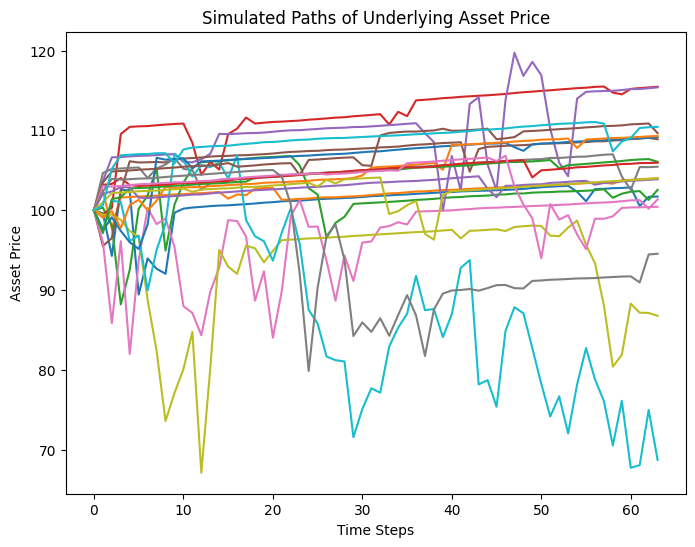

In [63]:
# Plotting paths of underlying asset price over time 

from matplotlib import pyplot as plt
simulated_paths = map_heston_output[Types.HESTON_OUTPUT.PATHS]

# Plot the simulated paths
plt.figure(figsize=(8, 6))
for i in range(20):
    plt.plot(simulated_paths[i])
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.title('Simulated Paths of Underlying Asset Price')
plt.show()

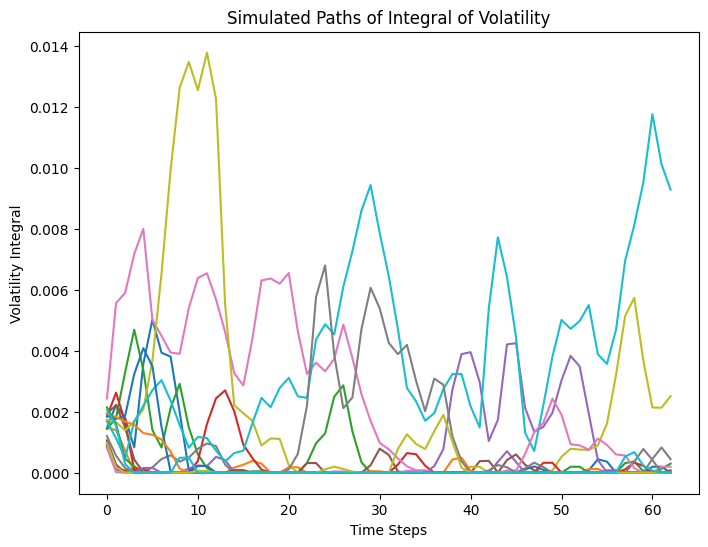

In [69]:
# Plotting paths of variance 
from matplotlib import pyplot as plt
simulated_variance_paths = map_heston_output[Types.HESTON_OUTPUT.INTEGRAL_VARIANCE_PATHS]

plt.figure(figsize=(8, 6))
for i in range(20):
    plt.plot(simulated_variance_paths[i])
plt.xlabel('Time Steps')
plt.ylabel('Volatility Integral')
plt.title('Simulated Paths of Integral of Volatility')
plt.show()

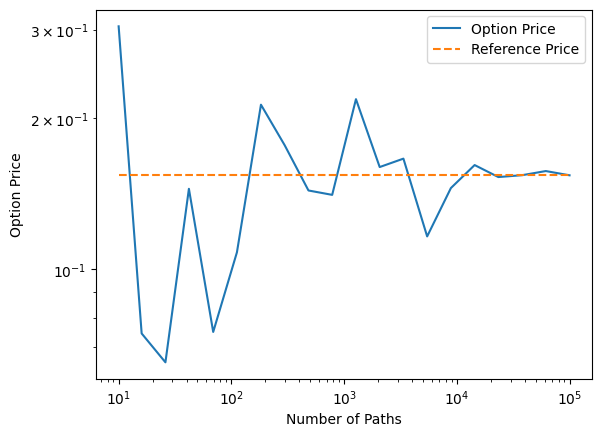

In [70]:
# Plotting convergence: prices 

# Define range of number of paths
path_range = np.logspace(1, 5, num=20, dtype=int)

# Define list to store option prices
option_prices = []

# Compute option prices for each number of paths
for no_paths in path_range:
    rnd_generator = RNG.RndGenerator(seed)
    map_heston_output = Heston_Engine.get_path_multi_step(0.0, T, parameters, f0, v0, no_paths,
                                                          no_time_steps, Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC,
                                                          rnd_generator)
    result = european_option.get_price(map_heston_output[Types.HESTON_OUTPUT.PATHS])
    option_prices.append(result[0])

# Plot convergence
fig, ax = plt.subplots()
ax.loglog(path_range, option_prices, label='Option Price')
ax.loglog(path_range, [option_prices[-1]]*len(path_range), '--', label='Reference Price')
ax.set_xlabel('Number of Paths')
ax.set_ylabel('Option Price')
ax.legend()
plt.show()


In [74]:
heston_delta_fd # reference delta

0.029838445273017156

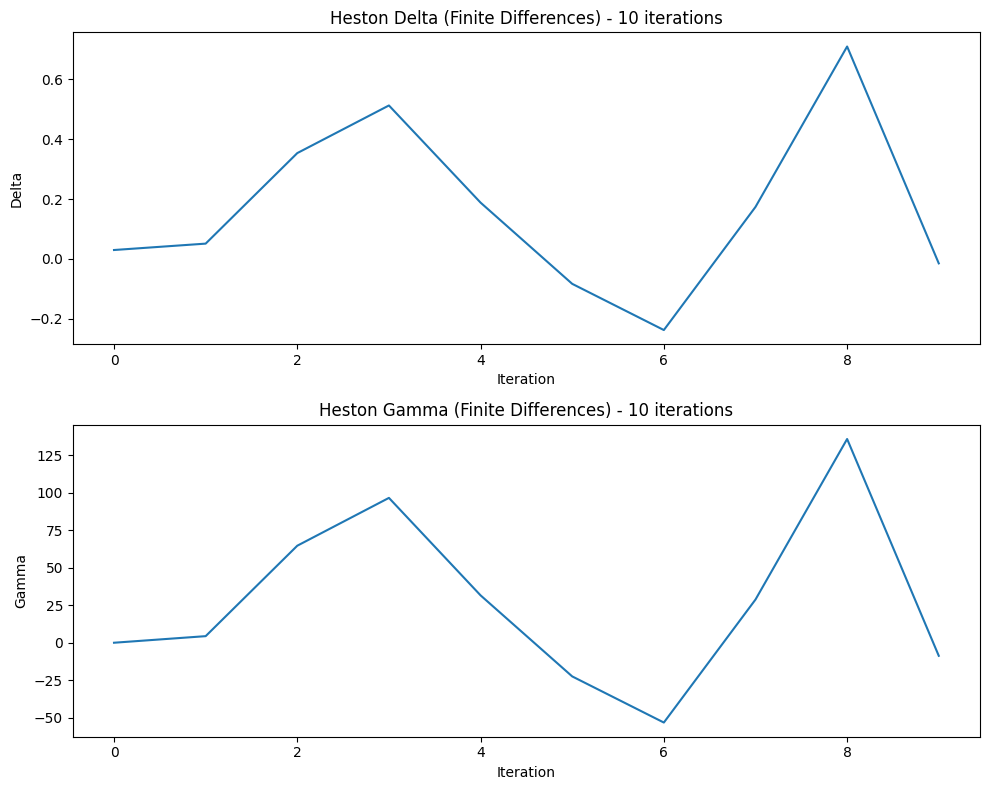

In [68]:
# Plotting convergence: Greeks 
import matplotlib.pyplot as plt
import numpy as np

# Set number of iterations
n_iterations = 10 # This takes VERY long!!!! 

# Initialize arrays to store delta and gamma results
heston_delta_fds = np.zeros(n_iterations)
heston_gamma_fds = np.zeros(n_iterations)

# Run simulation multiple times and store results
for i in range(n_iterations):
    # Compute delta and gamma using finite differences
    rnd_generator.set_seed(seed + i)  # Set new seed for each iteration
    map_heston_output_shift = Heston_Engine.get_path_multi_step(0.0, T, parameters, f0_shift, v0, no_paths, no_time_steps,
                                                                Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC, rnd_generator)
    result_shift = european_option.get_price(map_heston_output_shift[Types.HESTON_OUTPUT.PATHS])
    heston_delta_fds[i] = (result_shift[0] - result[0]) / (delta_shift * f0)

    rnd_generator.set_seed(seed + i)  # Set new seed for each iteration
    map_heston_output_shift_left = Heston_Engine.get_path_multi_step(0.0, T, parameters, f0_shift_left, v0, no_paths,
                                                                     no_time_steps,
                                                                     Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC,
                                                                     rnd_generator)
    result_shift_left = european_option.get_price(map_heston_output_shift_left[Types.HESTON_OUTPUT.PATHS])
    heston_gamma_fds[i] = (result_shift[0] - 2 * result[0] + result_shift_left[0]) / (delta_shift * f0) ** 2

# Plot results
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(heston_delta_fds)
axs[0].set_title('Heston Delta (Finite Differences) - ' + str(n_iterations) + ' iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Delta')

axs[1].plot(heston_gamma_fds)
axs[1].set_title('Heston Gamma (Finite Differences) - ' + str(n_iterations) + ' iterations')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Gamma')

plt.tight_layout()
plt.show()
